In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm


# Train data analysis

In [2]:
train_data = dict()

envs = ['halfcheetah', 'hopper', 'walker2d']
datasets = ['expert', 'medium_replay', 'medium']
data_features = ['observations', 'next_observations', 'actions', 'rewards', 'terminals']

for e in envs:
    for d in datasets:
        with open(f'./data_plus_plus/{e}-{d}-v2.pkl', 'rb') as f:
            train_data[f'{e}-{d}'] = pickle.load(f)

In [3]:
# for each dataset, combine all trajectories into a single long one
def concatenate_dataset(dataset):
    keys = list(dataset[0].keys())

    total_dict = dict()
    for key in keys:
        total_dict[key] = dataset[0][key]

    for traj in dataset[1:]:
        for key in keys:
            total_dict[key] = np.append(total_dict[key], traj[key], axis=0)
    
    return total_dict

concatenated_train_data = {k: concatenate_dataset(v) for k, v in tqdm(train_data.items())}


100%|██████████| 9/9 [02:19<00:00, 15.49s/it]


In [4]:
from sklearn.linear_model import LinearRegression

# calculate the weights of the individual parts of the reward using linear regression
def get_coef(data_temp):
    forward_reward = data_temp['observations'][:,5]
    ctrl_cost = (data_temp['actions'] ** 2).sum(axis=1)
    healthy_reward = np.array(~data_temp['terminals'], dtype=int)

    target_reward = data_temp['rewards']


    X = np.stack((forward_reward, ctrl_cost, healthy_reward), axis=0).T

    reg = LinearRegression().fit(X, target_reward)

    r_score = reg.score(X, target_reward)
    
    return reg.coef_, r_score # (forward_reward_weight, ctrl_cost_weight, healthy_reward), r_score

In [5]:
idxs = [f'{e}-{d}' for e in envs for d in datasets]
df_train_data = pd.DataFrame(index=idxs)

df_train_data['mean_terminals'] = [np.mean([sum(data['terminals']) for data in train_data[idx]]) for idx in idxs]
df_train_data['mean_terminal_reward'] = [np.mean([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['std_terminal_reward'] = [np.std([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['n_traj'] = [len(train_data[idx]) for idx in idxs]

df_train_data

,mean_terminals,mean_terminal_reward,std_terminal_reward,n_traj
halfcheetah-expert,0.000000,10656.426460,441.682728,1000
halfcheetah-medium_replay,0.000000,3093.285581,1680.693937,202
halfcheetah-medium,0.000000,4770.334765,355.750394,1000
hopper-expert,0.086660,3511.357707,328.585955,1027
hopper-medium_replay,0.803038,467.302044,511.025583,2041
hopper-medium,0.999543,1422.056180,378.953696,2186
walker2d-expert,0.001000,4920.507113,136.394925,1000
walker2d-medium_replay,0.723696,682.701247,895.955582,1093
walker2d-medium,0.431092,2852.088416,1095.443313,1190


In [6]:
def get_control_cost(actions):
    return np.sum(np.square(actions), axis=1)

def get_forward_reward(qpos):
    return (np.roll(qpos[:,0], -1) - qpos[:,0])



In [7]:
list(concatenated_train_data.keys())

['halfcheetah-expert',
 'halfcheetah-medium_replay',
 'halfcheetah-medium',
 'hopper-expert',
 'hopper-medium_replay',
 'hopper-medium',
 'walker2d-expert',
 'walker2d-medium_replay',
 'walker2d-medium']

In [8]:
data_temp = concatenated_train_data[list(concatenated_train_data.keys())[8]]

forward_reward = get_forward_reward(data_temp['infos/qpos'])
ctrl_cost = get_control_cost(data_temp['actions'])
healthy_reward = np.array(~data_temp['terminals'], dtype=int)
target_reward = data_temp['rewards']


X = np.stack((forward_reward, ctrl_cost, healthy_reward), axis=0).T

reg = LinearRegression().fit(X, target_reward)

r_score = reg.score(X, target_reward)

reg.coef_, r_score # (forward_reward_weight, ctrl_cost_weight, healthy_reward), r_score

(array([-0.00483203,  0.54901724, -0.81850446]), 0.1639008545951448)

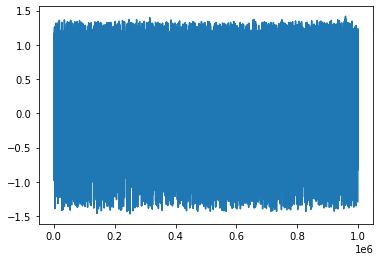

In [9]:
plt.plot(data_temp['infos/qpos'][:,5])

In [10]:
forward_reward_weights, ctrl_cost_weights, healthy_rewards, r_scores = [], [], [], []

for idx in idxs:
    e, d = idx.split('-')
    total_dict = concatenated_train_data[idx]

    if 1:
        (forward_reward_weight, ctrl_cost_weight, healthy_reward), r_score = get_coef(total_dict)

        forward_reward_weights.append(forward_reward_weight)
        ctrl_cost_weights.append(ctrl_cost_weight)
        healthy_rewards.append(healthy_reward)
        r_scores.append(r_score)
    else:
        forward_reward_weights.append(0)
        ctrl_cost_weights.append(0)
        healthy_rewards.append(0)
        r_scores.append(0)

df_train_data['forward_reward_weight'] = forward_reward_weights
df_train_data['ctrl_cost_weight'] = ctrl_cost_weights
df_train_data['healthy_reward'] = healthy_rewards
df_train_data['r_score'] = r_scores

In [11]:
df_train_data

,mean_terminals,mean_terminal_reward,std_terminal_reward,n_traj,forward_reward_weight,ctrl_cost_weight,healthy_reward,r_score
halfcheetah-expert,0.000000,10656.426460,441.682728,1000,0.330368,0.371123,0.000000,0.034664
halfcheetah-medium_replay,0.000000,3093.285581,1680.693937,202,-0.457160,0.465307,0.000000,0.068300
halfcheetah-medium,0.000000,4770.334765,355.750394,1000,-0.157705,0.121267,0.000000,0.009648
hopper-expert,0.086660,3511.357707,328.585955,1027,0.990445,-0.009995,0.020180,0.994152
hopper-medium_replay,0.803038,467.302044,511.025583,2041,0.998716,0.003028,0.015211,0.998170
hopper-medium,0.999543,1422.056180,378.953696,2186,0.994857,0.003238,0.026621,0.997427
walker2d-expert,0.001000,4920.507113,136.394925,1000,5.043629,0.171745,2.672657,0.047030
walker2d-medium_replay,0.723696,682.701247,895.955582,1093,2.531877,0.464810,0.052533,0.205862
walker2d-medium,0.431092,2852.088416,1095.443313,1190,2.884367,0.487274,-1.022832,0.443619


In [12]:
idxs

['halfcheetah-expert',
 'halfcheetah-medium_replay',
 'halfcheetah-medium',
 'hopper-expert',
 'hopper-medium_replay',
 'hopper-medium',
 'walker2d-expert',
 'walker2d-medium_replay',
 'walker2d-medium']

In [13]:
data_temp = concatenated_train_data['hopper-medium']


forward_reward = data_temp['observations'][:,5]
ctrl_cost = (data_temp['actions'] ** 2).sum(axis=1)
healthy_reward = np.array(~data_temp['terminals'], dtype=int)

target_reward = data_temp['rewards']


X = np.stack((forward_reward[:-1], ctrl_cost[1:], healthy_reward[1:]), axis=0).T
# X = forward_reward[:-1].reshape(-1, 1)
y = target_reward[:-1]

reg = LinearRegression().fit(X, y)

r_score = reg.score(X, y)

reg.coef_, r_score

(array([ 0.9952599 , -0.00104352,  0.0251373 ]), 0.9974211946023086)

# Plots

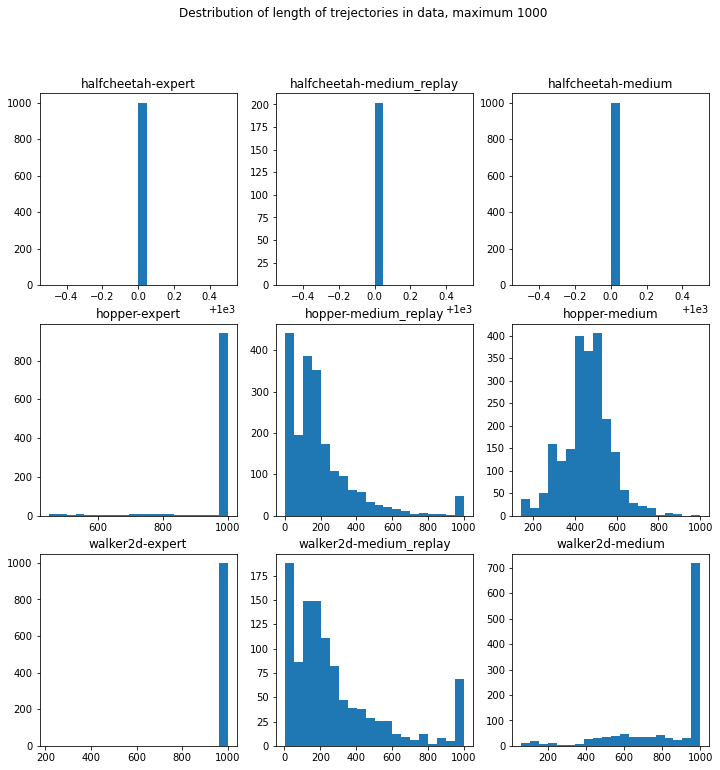

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12)) # note that halfcheetah does not terminate early, has no "survive" feature
fig.suptitle('Destribution of length of trejectories in data, maximum 1000')

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    lengths = [len(data['rewards']) for data in train_data[key]]
    ax.set_title(key)
    ax.hist(lengths, bins=20)

plt.show()

In [15]:
list(train_data.keys())

['halfcheetah-expert',
 'halfcheetah-medium_replay',
 'halfcheetah-medium',
 'hopper-expert',
 'hopper-medium_replay',
 'hopper-medium',
 'walker2d-expert',
 'walker2d-medium_replay',
 'walker2d-medium']

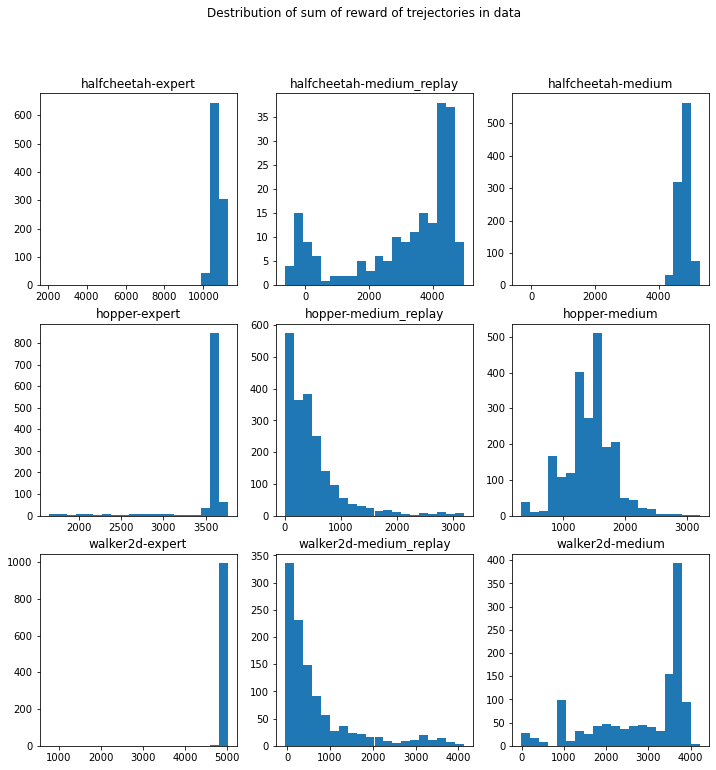

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Destribution of sum of reward of trejectories in data')

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    terminal_rewards = [sum(data['rewards']) for data in train_data[key]]
    ax.set_title(key)
    ax.hist(terminal_rewards, bins=20)

plt.show()

# Evaluation analysis

In [17]:
eval_path = './evaluation_data/'
raw_eval_dict = dict()

for env in os.listdir(eval_path):
    eval_path = './evaluation_data/'

    if not env == 'first_run_expert':

        eval_path += env + '/'
        for dataset in os.listdir(eval_path):
            
            eval_path += dataset + '/'
            for filename in os.listdir(eval_path):
                with open(eval_path + filename, 'rb') as f:
                    raw_eval_dict[filename] = pickle.load(f)

In [18]:
list(raw_eval_dict.keys())

['iter10-gym-experiment-hopper-medium_replay-745424',
 'iter5-gym-experiment-hopper-medium_replay-745424',
 'iter15-gym-experiment-hopper-medium_replay-745424',
 'iter10-gym-experiment-walker2d-medium_replay-799611',
 'iter5-gym-experiment-walker2d-medium_replay-799611',
 'iter15-gym-experiment-walker2d-medium_replay-799611',
 'iter15-gym-experiment-halfcheetah-medium_replay-511017',
 'iter10-gym-experiment-halfcheetah-medium_replay-511017',
 'iter5-gym-experiment-halfcheetah-medium_replay-511017']

In [19]:
def read_data_to_DataFrama(raw_dict):

    return_keys = [key for key in raw_dict.keys() if '_returns' in key]
    temp_dict = dict()
    for key in return_keys:
        target_return, _ = key.split('_')
        target_return = int(target_return)
        temp_dict[target_return] = raw_dict[key]
    
    return pd.DataFrame(temp_dict)

eval_dict = {k: read_data_to_DataFrama(v) for k, v in raw_eval_dict.items()}

In [20]:
list(eval_dict.keys())

['iter10-gym-experiment-hopper-medium_replay-745424',
 'iter5-gym-experiment-hopper-medium_replay-745424',
 'iter15-gym-experiment-hopper-medium_replay-745424',
 'iter10-gym-experiment-walker2d-medium_replay-799611',
 'iter5-gym-experiment-walker2d-medium_replay-799611',
 'iter15-gym-experiment-walker2d-medium_replay-799611',
 'iter15-gym-experiment-halfcheetah-medium_replay-511017',
 'iter10-gym-experiment-halfcheetah-medium_replay-511017',
 'iter5-gym-experiment-halfcheetah-medium_replay-511017']

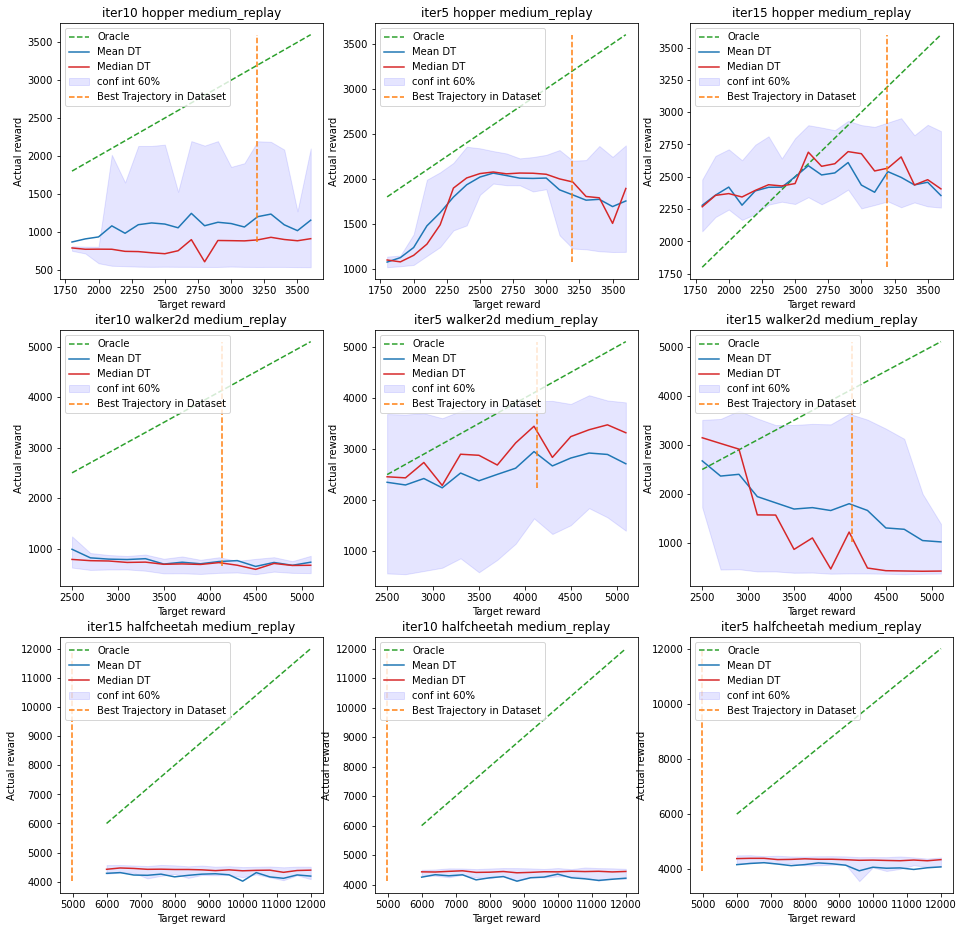

In [33]:
conf_int = (0.2, 0.8)


def get_plot_statistics(df, conf_int=(0.05, 0.95)):

    target_rewards = df.columns.to_numpy()
    reward_mean = df.to_numpy().mean(axis=0)
    reward_median = np.quantile(df.to_numpy(), 0.5, axis=0)
    # reward_std = df.to_numpy().std(axis=0)
    q_low, q_high = np.quantile(df.to_numpy(), conf_int, axis=0)

    return target_rewards, reward_mean, reward_median, q_low, q_high


plot_dict = {k: get_plot_statistics(v, conf_int=conf_int) for k, v in eval_dict.items()}




fig, axs = plt.subplots(3, 3, figsize=(16,16))

for ax, (exp_name, values) in zip(axs.flatten(), plot_dict.items()):
    x, y_mean, y_median, q_low, q_high = values

    x_linear = np.linspace(min(x), max(x))
    ax.plot(x_linear, x_linear, '--', c='C2', label='Oracle')
    ax.plot(x, y_mean, c='C0', label='Mean DT')
    ax.plot(x, y_median, c='C3', label='Median DT')
    ax.fill_between(x, q_low, q_high, color='b', alpha=.1, label=f'conf int {int((conf_int[1]-conf_int[0])*100)}%')

    train_data_name = '-'.join(np.take(exp_name.split('-'), (3,4)))
    terminal_rewards = [sum(data['rewards']) for data in train_data[train_data_name]]
    ax.vlines(max(terminal_rewards), min(min(y_mean), min(x_linear)),
        max(max(y_mean), max(x_linear)), linestyles='--', colors='C1', label='Best Trajectory in Dataset')


    ax.set_title(' '.join(np.take(exp_name.split('-'), (0,3,4))))
    ax.legend(loc="upper left")
    ax.set_xlabel('Target reward')
    ax.set_ylabel('Actual reward')

plt.show()